In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neural_network import MLPRegressor
from scipy.stats import ttest_1samp
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error

In [3]:
# Load data
data = pd.read_csv('winequality_red_modified.csv')

In [4]:
X = data.drop('quality', axis=1)
y = data['quality']


In [5]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [7]:
regressor = MLPRegressor(hidden_layer_sizes=(30, 30), max_iter=500, activation='relu', random_state=1)
regressor.fit(X_train_scaled, y_train)

MLPRegressor(hidden_layer_sizes=(30, 30), max_iter=500, random_state=1)

In [8]:
# prediction
y_pred = regressor.predict(X_test_scaled)

# accuracy under tolerance
tolerance = 0.25
correct_within_tolerance = (np.abs(y_pred - y_test) <= tolerance)

tolerance_accuracy = np.mean(correct_within_tolerance)

print("容忍度为 {} 内的准确率: {:.2f}%".format(tolerance, tolerance_accuracy * 100))



容忍度为 0.25 内的准确率: 35.94%


In [9]:
tolerances = np.linspace(0.0, 2.0, 200)
accuracies = []

for tolerance in tolerances:

    accurate_predictions = np.abs(y_pred - y_test) <= tolerance
    accuracy = np.mean(accurate_predictions)
    accuracies.append(accuracy)

# plot
plt.figure(figsize=(10, 6))
plt.plot(tolerances, accuracies,  linestyle='-', color='b', linewidth=4)
plt.title('Accuracy vs. Tolerance for Red Wine Quality Prediction Model')
plt.xlabel('Tolerance')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

In [10]:
# Sensitivity Analysis
# mean value
feature_means = X_train_scaled.mean(axis=0)

# variances
variances = []

# for each features
for i in range(X_train_scaled.shape[1]):
    temp = feature_means.copy()
    
    # max and min
    min_val = X_train_scaled[:, i].min()
    max_val = X_train_scaled[:, i].max()
    
   
    feature_range = np.linspace(min_val, max_val, 100)
    
   
    outputs = []
    for val in feature_range:
        temp[i] = val
        outputs.append(regressor.predict([temp])[0])
    
    
    variance = np.var(outputs)
    variances.append(variance)


total_variance = sum(variances)


relative_importances = [v / total_variance * 100 for v in variances]
print(relative_importances)
# plot
plt.figure(figsize=(10, 6))
plt.bar(range(X_train_scaled.shape[1]), relative_importances, tick_label=X.columns)
plt.xlabel('Feature')
plt.ylabel('Relative Importance (%)')
plt.title('Red Wine Feature Importance Using Sensitivity Analysis')
plt.xticks(rotation=90)
plt.show()

[6.049545670165308, 18.15566506855251, 5.3400976269486735, 1.961064875859709, 26.28992440104083, 2.038801099888734, 7.754855564598315, 7.620994010167282, 0.4876205012670609, 8.163705350758658, 16.13772583075292]


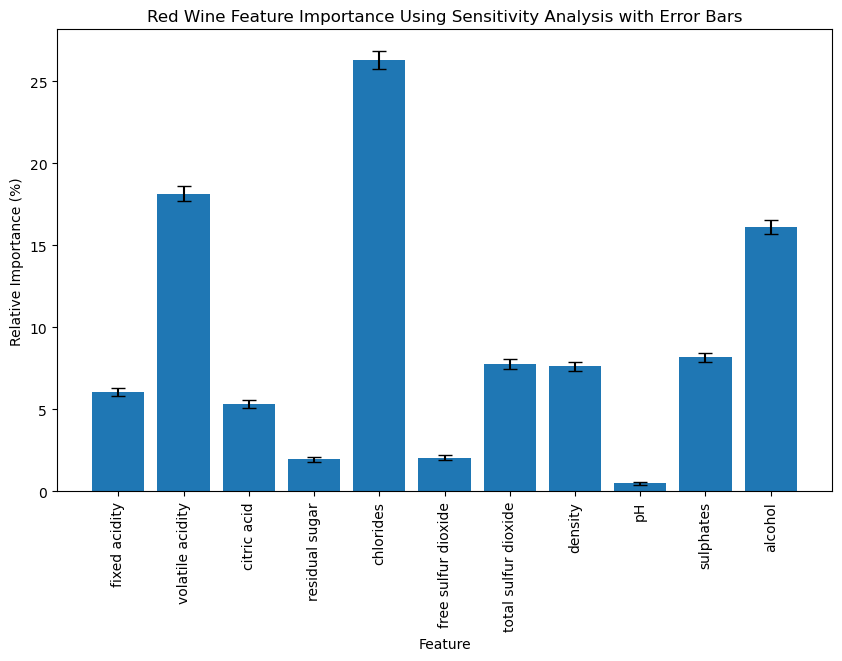

[0.26187341352675797, 0.45366587291006827, 0.24603938219371876, 0.14909943922440796, 0.5459145858933153, 0.152025856558387, 0.29649466696764604, 0.2939245348467329, 0.07434829401627438, 0.30421014296250276, 0.4277117643580386]


In [14]:
variances = []
std_devs = []  

for i in range(X_train_scaled.shape[1]):
    temp = feature_means.copy()
    min_val = X_train_scaled[:, i].min()
    max_val = X_train_scaled[:, i].max()
    feature_range = np.linspace(min_val, max_val, 100)
    
    outputs = []
    for val in feature_range:
        temp[i] = val
        outputs.append(regressor.predict([temp])[0])
    
    variance = np.var(outputs)
    std_dev = np.std(outputs)  
    variances.append(variance)
    std_devs.append(std_dev) 

total_variance = sum(variances)
relative_importances = [v / total_variance * 100 for v in variances]


plt.figure(figsize=(10, 6))
x_ticks = np.arange(len(X.columns)) 
plt.bar(x_ticks, relative_importances, yerr=std_devs, capsize=5, tick_label=X.columns)
plt.xlabel('Feature')
plt.ylabel('Relative Importance (%)')
plt.title('Red Wine Feature Importance Using Sensitivity Analysis with Error Bars')
plt.xticks(rotation=90)
plt.show()
print(std_devs)

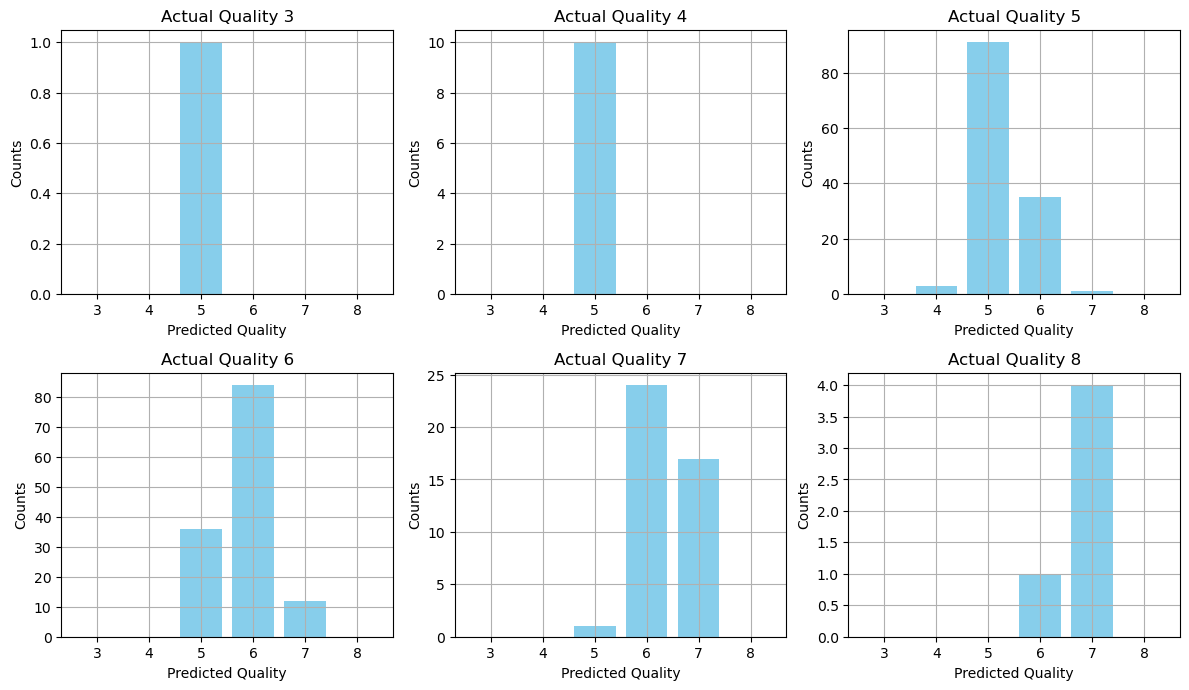

In [18]:
def round_with_tolerance(values, tolerance=0.5):
    fractional_part = values - np.floor(values)
    rounded_values = np.where(fractional_part <= tolerance, np.floor(values), np.ceil(values))
    return rounded_values.astype(int)

y_pred_rounded_with_tolerance = round_with_tolerance(y_pred, tolerance=0.5)


quality_values = sorted(np.unique(y_test))
results_with_tolerance = {}

for q in quality_values:
    mask = y_test == q
    predictions_for_q = y_pred_rounded_with_tolerance[mask]
    counts = {pred: np.sum(predictions_for_q == pred) for pred in quality_values}
    results_with_tolerance[q] = counts

plt.figure(figsize=(12, 10))
for i, q in enumerate(quality_values):
    plt.subplot(3, 3, i + 1)
    values = [results_with_tolerance[q].get(pred, 0) for pred in quality_values]
    plt.bar(quality_values, values, color='skyblue')
    plt.title(f'Actual Quality {q}')
    plt.xlabel('Predicted Quality')
    plt.ylabel('Counts')
    plt.grid(True)

plt.tight_layout()
plt.show()

Confusion Matrix:
 [[ 0  0  1  0  0  0]
 [ 0  0 10  0  0  0]
 [ 0  3 91 35  1  0]
 [ 0  0 36 84 12  0]
 [ 0  0  1 24 17  0]
 [ 0  0  0  1  4  0]]


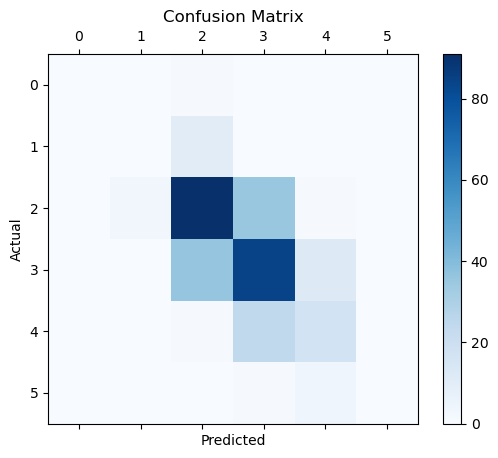

Accuracy: 60.00%
Accuracy within tolerance ±0.5: 60.00%
Accuracy within tolerance ±1.0: 92.19%


In [19]:
y_pred = regressor.predict(X_test_scaled)
y_pred_rounded = np.round(y_pred).astype(int)


cm = confusion_matrix(y_test, y_pred_rounded)
print("Confusion Matrix:\n", cm)


fig, ax = plt.subplots()
cax = ax.matshow(cm, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix')
plt.show()

accuracy = accuracy_score(y_test, y_pred_rounded)
print("Accuracy: {:.2f}%".format(accuracy * 100))


tolerances = [0.5, 1.0]
for tol in tolerances:
    correct_within_tolerance = (np.abs(y_pred - y_test) <= tol)
    accuracy_within_tolerance = np.mean(correct_within_tolerance)
    print(f"Accuracy within tolerance ±{tol}: {accuracy_within_tolerance * 100:.2f}%")

In [20]:
def categorize_with_tolerance(y_pred, y_classes, tolerance=0.5):
    categorized_preds = []
    for pred in y_pred:
    
        distances = np.abs(y_classes - pred)
    
        min_distance = np.min(distances)
        if min_distance <= tolerance:
           
            closest_category = y_classes[np.argmin(distances)]
            categorized_preds.append(closest_category)
        else:
           
            categorized_preds.append(-1)
    return np.array(categorized_preds)


y_classes = np.array(sorted(np.unique(y_test)))
y_pred_categorized = categorize_with_tolerance(y_pred, y_classes, tolerance=0.5)


cm = confusion_matrix(y_test, y_pred_categorized)
print("Confusion Matrix:\n", cm)


plt.figure(figsize=(10, 6))
plt.matshow(cm, cmap=plt.cm.Blues, fignum=1)
plt.colorbar()
plt.xlabel('Predicted Categories')
plt.ylabel('Actual Categories')
plt.title('Confusion Matrix with Tolerance')
plt.show()

Confusion Matrix:
 [[ 0  0  1  0  0  0]
 [ 0  0 10  0  0  0]
 [ 0  3 91 35  1  0]
 [ 0  0 36 84 12  0]
 [ 0  0  1 24 17  0]
 [ 0  0  0  1  4  0]]


In [51]:
def get_permutation_scores(X, y, model, n_permutations=100):
    scores = np.zeros(n_permutations)
    predictions = model.predict(X)
    real_score = mean_squared_error(y, predictions)  # 使用MSE作为实际分数

    for i in range(n_permutations):
        y_permuted = np.random.permutation(y)
        permuted_score = mean_squared_error(y_permuted, predictions)
        scores[i] = permuted_score

    return scores, real_score

In [53]:
scores, real_score = get_permutation_scores(X_test, y_test, model, 1000)
p_value = np.mean(scores >= real_score)
print(f"P-value: {p_value}")

10/10 [==============================] - 0s 667us/step
P-value: 0.017


In [57]:
def get_permutation_scores(X, y, model, n_permutations=100):
    scores = np.zeros(n_permutations)
    predictions = model.predict(X)
    real_score = accuracy_score(y, predictions)
    for i in range(n_permutations):
        y_permuted = np.random.permutation(y)
        scores[i] = accuracy_score(y_permuted, predictions)
    return scores, real_score
    

In [3]:
from itertools import combinations
from sklearn.model_selection import cross_val_score

def load_and_process(path):
    df = pd.read_csv(path, sep=';')
    data = df.values
    np.random.shuffle(data)
    X, y = data[:, :-1], data[:, -1].astype(int)
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    return X, y

def combinations_without_replacement(n, m):
    """
    n: number of elements
    m: number of elements to choose
    """
    comb = list(combinations(range(n), m))
    return np.array(comb)

# X, y = load_and_process('winequality_red_modified.csv')
df = pd.read_csv('winequality_red_modified.csv')
data = df.values
np.random.shuffle(data)
X, y = data[:, :-1], data[:, -1].astype(int)
scaler = StandardScaler()
X = scaler.fit_transform(X)
n_samples, n_features = X.shape

def get_accuracy(model, remove_features, n_splits=10):
    X_cleaned = np.delete(X, remove_features, axis=1)
    cv_scores = cross_val_score(model, X_cleaned, y, cv=n_splits, scoring='neg_mean_squared_error')
    cv_score_mean = np.mean(cv_scores)
    cv_score_std = np.std(cv_scores)
    return cv_score_mean, cv_score_std

def get_importances_remove(model, n_splits=10, depth=2):
    combs = combinations_without_replacement(n_features, depth)
    n_combs = combs.shape[0]
    importances = np.zeros(n_combs)
    for i, comb in enumerate(combs):
        print(i)
        to_remove = np.array(comb)
        importances[i] = get_accuracy(model, to_remove, n_splits=n_splits)[0]
    return combs, importances


regressor = MLPRegressor(hidden_layer_sizes=(30, 30), max_iter=500, activation='relu', random_state=1)
feats, importances = get_importances_remove(regressor, n_splits=5)

0


D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\envs\DataScienceCour

1


D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\envs\DataScienceCour

2


D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\envs\DataScienceCour

3


D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\envs\DataScienceCour

4


D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


5


D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\envs\DataScienceCour

6


D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


7


D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


8


D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\envs\DataScienceCour

9


D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\envs\DataScienceCour

10


D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


11


D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


12


D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


13


D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


14


D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\envs\DataScienceCour

15


D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\envs\DataScienceCour

16


D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


17


D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\envs\DataScienceCour

18


D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


19


D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\envs\DataScienceCour

20


D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


21


D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


22


D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\envs\DataScienceCour

23


D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


24


D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\envs\DataScienceCour

25


D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


26


D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


27


D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


28


D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


29


D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\envs\DataScienceCour

30


D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


31


D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\envs\DataScienceCour

32


D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


33


D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


34


D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


35


D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


36


D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\envs\DataScienceCour

37


D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


38


D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\envs\DataScienceCour

39


D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\envs\DataScienceCour

40


D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


41


D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\envs\DataScienceCour

42


D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


43


D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\envs\DataScienceCour

44


D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


45


D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\envs\DataScienceCour

46


D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\envs\DataScienceCour

47


D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


48


D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\envs\DataScienceCour

49


D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\envs\DataScienceCour

50


D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\envs\DataScienceCour

51


D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\envs\DataScienceCour

52


D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


53


D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


54


D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\envs\DataScienceCourse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


In [8]:
fontsize_label = 14
fontsize_ticks = 12
fontsize_title = 20

n = len(feats)

plt.figure(figsize=(12, 6))
plt.plot(range(n), -importances)
plt.grid()
plt.ylim(0, 1)
plt.title(f'Training RF with Removed Features ({56} Combinations)', fontsize=fontsize_title)
plt.xlabel('Removed Features (Arbitrary Ordering)', fontsize=fontsize_label)
plt.ylabel('Accuracy', fontsize=fontsize_label)

n = len(feats)

"""
labels_new = [label.split() for label in labels]
initials = []
for label in labels_new:
    initials.append(''.join([word[0] for word in label]).upper())

tick_combs = [feats[i] for i in range(0, n, 30)]
tick_labels = [[initials[j] for j in comb] for comb in tick_combs]
"""

print(importances)

# plt.xticks(range(0, n, 30), tick_labels, rotation=45)
# plt.savefig('./preselection.png', dpi=300, bbox_inches='tight')

[-0.44303279 -0.43156414 -0.40928896 -0.40760074 -0.42747478 -0.43106806
 -0.41367639 -0.42973079 -0.45562101 -0.44361032 -0.43199168 -0.42587879
 -0.43126802 -0.43577321 -0.43862498 -0.42998024 -0.43623004 -0.47728387
 -0.44197736 -0.42464288 -0.430176   -0.4381132  -0.46236645 -0.43021753
 -0.42298039 -0.46279702 -0.45436449 -0.41997579 -0.41722342 -0.44261774
 -0.41912168 -0.41724837 -0.44396899 -0.45792887 -0.41935174 -0.44617572
 -0.41786106 -0.42884434 -0.45727851 -0.44872925 -0.41477979 -0.43715596
 -0.43263295 -0.45933852 -0.44707896 -0.42669923 -0.44941767 -0.4746871
 -0.46486617 -0.44069434 -0.46809514 -0.49332399 -0.47058232 -0.45606575
 -0.4925433 ]
